<strong>Stream Cipher Cryptanalysis with <font color='blue'> Known Plaintext Attack </font> </strong>

We construct a PRNG that is then used to define a stream cipher that is used bitwise XOR with the bits generated by the PRNG.

By the way, the PRNG we define is a  <font color='blue'> Linear Congruential Generator</font>. This means, it is defined using a recursive linear recurrence of the following type:
$$ \left\{\begin{array}{llll} S_1 & =&  \text{seed} &  \\  S_{i+1} &=& A\cdot S_i + B \mod m & i=1,2,\cdots \end{array}\right.$$ 
Moreover:


 - <strong> Each PRNG output $S_i$ is a 100-bit integer. </strong>
 - <strong>  These $S_i$ values are broken down into individual bits $s_i$ (bitstream). </strong> 
 - <strong>  The encryption is done by XORing each plaintext bit $x_i$  with the keystream bit $s_i$:
     $$y_i = x_i  \oplus   s_i $$
 - <strong> So $S_1$ gives $s_1$ to $s_{100}$, $S_2$ gives $s_{101}$ to $s_{200}$, and so on. </strong> 
 - <strong> If Oscar knows the plaintext and ciphertext, he can recover the corresponding $s_i$ bits.</strong> 
 - <strong> With 300 known bits, Oscar can recover $S_1, S_2$, and $S_3$, which lets him solve:
     $$ S_2 = A\cdot S_1 + B \mod m $$
     $$ S_3 = A\cdot S_2 + B \mod m $$ </strong> 
 - <strong> This gives him a linear system to recover A and B (the key).</strong> 
 - <strong> If $\delta_1 = S_2 - S_1$ is invertible mod m, the key is uniquely determined! </strong> 


Additionally, we analyze the bit-level statistical properties of the keystream,
 checking whether the bits appear random by testing for uniformity (50% 0s, 50% 1s)
using a chi-squared test and visualizing with a histogram.

In [36]:
!pip install pycryptodome

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


1067443417595212780671488132029
Original message: A un amigo perdido. Ya no me recordaras en el pais extranjero
Original message in bits: 01000001001000000111010101101110001000000110000101101101011010010110011101101111001000000111000001100101011100100110010001101001011001000110111100101110001000000101100101100001001000000110111001101111001000000110110101100101001000000111001001100101011000110110111101110010011001000110000101110010011000010111001100100000011001010110111000100000011001010110110000100000011100000110000101101001011100110010000001100101011110000111010001110010011000010110111001101010011001010111001001101111
Bit length: 488
Recovered A correctly: True
Recovered B correctly: True

Recovered message: A un amigo perdido. Ya no me recordaras en el pais extranjero

[Statistical Analysis of Keystream Bits]
Total bits: 100000
Zeroes: 50235 (50.23%)
Ones:   49765 (49.77%)
Chi-squared statistic: 2.2090, p-value: 0.1372


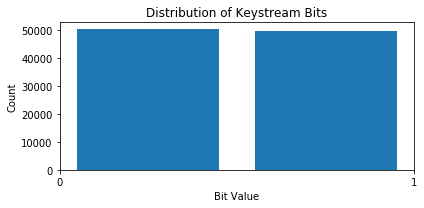

In [37]:
# Linear Congruential Generator (LCG) Stream Cipher Demonstration
# and Cryptanalysis with Known Plaintext Attack on Real Message

import random
from Crypto.Util.number import getPrime, inverse
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

# --- Setup: Define Parameters ---
m_bits = 100
m = getPrime(m_bits)  # publicly known modulus
print(m)
# Secret key (A, B): 100-bit integers
A = random.randint(0, m - 1)
B = random.randint(0, m - 1)

# PRNG: Linear Congruential Generator
def lcg(seed, A, B, m, n):
    s = [seed]
    for _ in range(n - 1):
        s.append((A * s[-1] + B) % m)
    return s

# Convert integer output to bits
def int_to_bits(x, bitlen=100):
    return bin(x)[2:].zfill(bitlen)

def bits_to_int(bits):
    return int(bits, 2)

# Convert text to bitstring
def text_to_bits(text):
    return ''.join(format(byte, '08b') for byte in text.encode('utf-8'))

def bits_to_text(bits):
    chars = [bits[i:i+8] for i in range(0, len(bits), 8)]
    return ''.join([chr(int(c, 2)) for c in chars])

# --- Encrypt function (Stream cipher) ---
def encrypt(plaintext_bits, seed):
    n_blocks = (len(plaintext_bits) + 99) // 100
    prng_output = lcg(seed, A, B, m, n_blocks)
    key_stream_bits = ''.join(int_to_bits(s) for s in prng_output)[:len(plaintext_bits)]
    ciphertext_bits = ''.join(str(int(x)^int(k)) for x, k in zip(plaintext_bits, key_stream_bits))
    return ciphertext_bits, prng_output

# --- Simulate Known Plaintext Attack ---
def recover_key_from_stream(S1, S2, S3):
    delta1 = (S2 - S1) % m
    delta2 = (S3 - S2) % m
    try:
        inv = inverse(delta1, m)
        A_rec = (delta2 * inv) % m
        B_rec = (S2 - A_rec * S1) % m
        return A_rec, B_rec
    except ValueError:
        return None, None

# --- Example with Real Message ---

# Step 1: Convert message to bits
real_message = "A un amigo perdido. Ya no me recordaras en el pais extranjero"
message_bits = text_to_bits(real_message)
print("Original message:", real_message)
print("Original message in bits:", message_bits)
print("Bit length:", len(message_bits))

# Step 2: Encrypt
seed = random.randint(0, m - 1)
ciphertext, prng_sequence = encrypt(message_bits, seed)

# Step 3: Simulate Oscar knowing first 300 bits
known_bits = 300
message_bits_known = message_bits[:known_bits]
ciphertext_known = ciphertext[:known_bits]

S1 = bits_to_int(ciphertext_known[:100]) ^ bits_to_int(message_bits_known[:100])
S2 = bits_to_int(ciphertext_known[100:200]) ^ bits_to_int(message_bits_known[100:200])
S3 = bits_to_int(ciphertext_known[200:300]) ^ bits_to_int(message_bits_known[200:300])

# Step 4: Oscar tries to recover key
A_guess, B_guess = recover_key_from_stream(S1, S2, S3)

if A_guess is not None:
    print("Recovered A correctly:", A_guess == A)
    print("Recovered B correctly:", B_guess == B)

    # Step 5: Decrypt using recovered key
    def decrypt(ciphertext_bits, seed, A, B):
        n_blocks = (len(ciphertext_bits) + 99) // 100
        keystream = lcg(seed, A, B, m, n_blocks)
        keystream_bits = ''.join(int_to_bits(s) for s in keystream)[:len(ciphertext_bits)]
        decrypted_bits = ''.join(str(int(c)^int(k)) for c, k in zip(ciphertext_bits, keystream_bits))
        return decrypted_bits

    recovered_bits = decrypt(ciphertext, seed, A_guess, B_guess)
    recovered_message = bits_to_text(recovered_bits)
    print("\nRecovered message:", recovered_message)
else:
    print("\nKey recovery failed: Non-invertible difference.")

# --- Statistical Analysis of the keystream bits ---

# Generate long keystream for analysis
long_keystream_bits = ''.join(int_to_bits(s) for s in lcg(seed, A, B, m, 1000))
bit_array = np.array([int(b) for b in long_keystream_bits])

# Frequency test: Expect close to 50% 0s and 1s
ones = np.sum(bit_array)
zeros = len(bit_array) - ones
print("\n[Statistical Analysis of Keystream Bits]")
print(f"Total bits: {len(bit_array)}")
print(f"Zeroes: {zeros} ({zeros / len(bit_array):.2%})")
print(f"Ones:   {ones} ({ones / len(bit_array):.2%})")

# Chi-squared test for uniformity
observed = [zeros, ones]
expected = [len(bit_array) / 2] * 2
chi2, p = chisquare(observed, expected)
print(f"Chi-squared statistic: {chi2:.4f}, p-value: {p:.4f}")

# Bit distribution histogram
plt.figure(figsize=(6, 3))
plt.hist(bit_array, bins=2, rwidth=0.8)
plt.xticks([0, 1])
plt.title("Distribution of Keystream Bits")
plt.xlabel("Bit Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()




In [38]:
print(ciphertext)

11100110101111101000100011010010010010000101010111111101100001111111011100110100111000011111011010100001011010010011011011011000100001110110010100000111100101110001001101001001000010110110110000100011000101110111101011100001000101110110010111001000011000110100010011011110001011100001010110001011000001110100000001001111010111011011000111100110111100101011011110001000010011001000001100001101110110110000101000100010111110111000000000110111101011000110001001010000110010010111111110110111


In [39]:
print(message_bits)

01000001001000000111010101101110001000000110000101101101011010010110011101101111001000000111000001100101011100100110010001101001011001000110111100101110001000000101100101100001001000000110111001101111001000000110110101100101001000000111001001100101011000110110111101110010011001000110000101110010011000010111001100100000011001010110111000100000011001010110110000100000011100000110000101101001011100110010000001100101011110000111010001110010011000010110111001101010011001010111001001101111


In [40]:
xor_result = int(message_bits, 2) ^ int(ciphertext, 2)
print(bin(xor_result)[2:].zfill(len(message_bits)))

10100111100111101111110110111100011010000011010010010000111011101001000001011011110000011000011011000100000110110101001010110001111000110000101000101001101101110100101000101000001010110000001001001100001101110001011110000100001101110001011110101101000000000010101110101100010010100111010011111001011001100011001101101111001110001101111111000110100101111101101110101000001111001110001001100100101010000010101001000111100000111111010001000101110011010000110000111010101011000000110111011000


In [41]:
prng_sequence

[830019282462089209556940626028,
 325368717286452757424895623756,
 272801683242844769911874998166,
 491287169932908964898597397672,
 209357236507738100343607496149]

In [42]:
int_to_bits(prng_sequence[0],100)

'1010011110011110111111011011110001101000001101001001000011101110100100000101101111000001100001101100'

In [43]:
int_to_bits(prng_sequence[1],100)

'0100000110110101001010110001111000110000101000101001101101110100101000101000001010110000001001001100'

In [44]:
int_to_bits(prng_sequence[2],100)

'0011011100010111100001000011011100010111101011010000000000101011101011000100101001110100111110010110'

In [45]:
int_to_bits(prng_sequence[3],100)

'0110001100110110111100111000110111111100011010010111110110111010100000111100111000100110010010101000'

In [46]:
int_to_bits(prng_sequence[4],100)

'0010101001000111100000111111010001000101110011010000110000111010101011000000110111011000110111010101'

Note that last digits of the key were not used. This is so because the length of the plaintext is smaller than 500!

In [50]:
len(int_to_bits(xor_result))

488